In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report,\
                            accuracy_score, confusion_matrix, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [57]:
# Leia o conjunto de dados
df = pd.read_excel('https://github.com/2025-2-NCC5/Projeto6/raw/main/documentos/dados_cannoli.xlsx', engine='openpyxl')
df.head()

,id,companyId,containerId,createdAt,customer,displayId,engineId,engineName,engineType,extraInfo,...,orderTiming,orderType,salesChannel,scheduledAt,status,preparationTime,takeOutTimeInSeconds,totalAmount,updatedAt,version
0,1,I0VP1DZXGU,AKVXT2FH,2025-01-08 15:47:00,525,O8CC98,E3R037,DirectOrder,POS,Adipisci maiores nam eius vero nesciunt sed.,...,IMMEDIATE,DELIVERY,ANOTAAI,NaT,DISPATCHED,45,2131,90.91,2025-01-09 03:32:00,v3.7.8
1,2,04MEUULZ6W,KKMY5TG5,2024-11-03 22:30:00,694,HJ99VA,EJVOBV,DirectOrder,APP,NaN,...,IMMEDIATE,DELIVERY,WHATSAPP,NaT,CONCLUDED,33,374,99.69,2024-11-04 03:05:00,v2.3.0
2,3,W2ZZS7CCZW,I87JLGTV,2024-09-09 05:49:00,491,XJJDH2,UDX1ZF,KDSPro,POS,NaN,...,IMMEDIATE,INDOOR,EPADOCA,NaT,CONCLUDED,22,247,45.97,2024-09-09 09:32:00,v1.9.5
3,4,SQ5MBL8L24,W3ZXOQHO,2025-05-22 06:22:00,846,J8QDM3,30FLOC,KDSPro,WEB,Autem mollitia voluptas quasi.,...,SCHEDULED,TAKEOUT,99FOOD,2025-05-22 14:22:00,CANCELED,35,1766,104.31,2025-05-22 21:39:00,v2.8.5
4,5,0RCNJ6BRJD,NA0C0FOS,2025-02-22 01:23:00,77,H4LV73,QI3URN,KDSPro,POS,NaN,...,SCHEDULED,DELIVERY,99FOOD,2025-02-24 11:23:00,DISPATCHED,20,1219,105.5,2025-02-22 13:53:00,v2.1.3


In [27]:
def freq(x: pd.Series, plot=False):
    contagem = x.value_counts()
    percentual = round((x.value_counts() / x.shape[0]) * 100, 3)
    res = pd.DataFrame({'n': contagem, 'perc': percentual})
    if plot:
        sns.countplot(x)
        plt.show()
    return res

Entendendo separação de vendas por canal

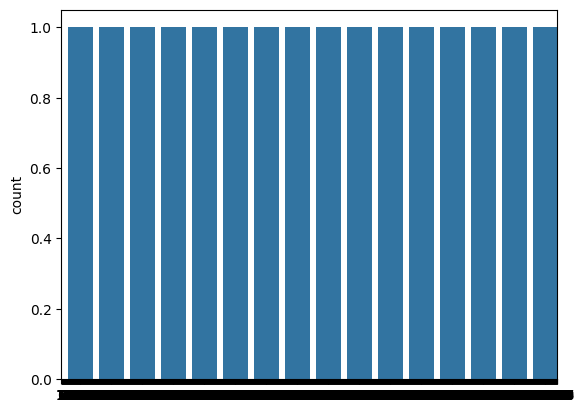

,n,perc
isTest,,
False,1911,95.55
True,89,4.45


In [28]:
freq(df['isTest'], plot=True)

Analisando dados de tempo de pedido de acordo com o tipo (delivery, retirada ou presencial)

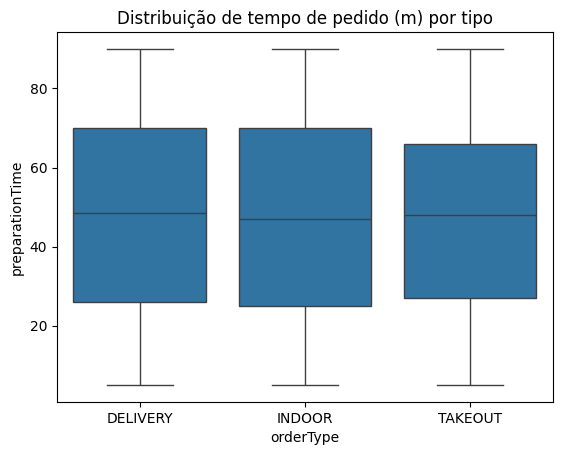

In [29]:
sns.boxplot(x='orderType', y='preparationTime', data=df)
plt.title('Distribuição de tempo de pedido (m) por tipo')
plt.show()

## Tratando os dados para mantermos somente o interessante para o modelo

In [59]:
df = df.dropna()
df['totalAmount'] = pd.to_numeric(df['totalAmount'], errors='coerce')
df = df.dropna(subset=['totalAmount'])

# Removendo linha de teste
df = df[(df['isTest'] == False)]

# # orderType → transforma em físico x delivery
# df['orderType_fisico'] = df['orderType'].isin(['INDOOR', 'TAKEOUT']).astype(int)
# df['orderType_delivery'] = (df['orderType'] == 'DELIVERY').astype(int)

# # salesChannel → externo x interno
# df['salesChannel_externo'] = df['salesChannel'].isin(['99FOOD','IFOOD','ANOTAAI','DELIVERYVIP','EPADOCA']).astype(int)
# df['salesChannel_interno'] = df['salesChannel'].isin(['WHATSAPP','SITE']).astype(int)

linhas = len(df)
print(linhas)

405


## Modelagem
Vamos utilizar o modelo para identificar quanto o tipo do pedido (delivery, retirada ou presencial) e o canal de venda impactam no valor gasto pelo cliente

Utilizamos o modelo Gaussiano considerando que nossa variável de gasto é uma variável descritiva, tornando impossivel a utilização de um modelo binário.

In [61]:
modelo = smf.glm(formula='totalAmount ~ C(orderType) + C(salesChannel)', data=df, family = sm.families.Gaussian()).fit()

print(modelo.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            totalAmount   No. Observations:                  405
Model:                            GLM   Df Residuals:                      396
Model Family:                Gaussian   Df Model:                            8
Link Function:               Identity   Scale:                          1335.1
Method:                          IRLS   Log-Likelihood:                -2027.5
Date:                Fri, 19 Sep 2025   Deviance:                   5.2869e+05
Time:                        00:30:57   Pearson chi2:                 5.29e+05
No. Iterations:                     3   Pseudo R-squ. (CS):            0.01032
Covariance Type:            nonrobust                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

## Interpretação dos parametros do modelo
Os pedidos por presenciais (retirada ou no local) representam um aumento de 10,50 no valor gasto, enquanto o delivery aumenta em média 21,10. Ou seja, os pedidos realizados no delivery tendem a ser mais caros, considerando apenas esses dados.

Quando o canal de venda utilizado é o interno (Whatsapp ou Site) vemos que isso impacta em um aumento médio de 23,00, o que representa mais de 200% quando comparamos com o impacto do canal externo.

In [62]:
print(modelo.params)

Intercept                         59.744501
C(orderType)[T.INDOOR]            -3.151306
C(orderType)[T.TAKEOUT]           -5.320078
C(salesChannel)[T.ANOTAAI]         6.373714
C(salesChannel)[T.DELIVERYVIP]     8.673191
C(salesChannel)[T.EPADOCA]         3.134962
C(salesChannel)[T.IFOOD]           6.919463
C(salesChannel)[T.SITE]            2.266868
C(salesChannel)[T.WHATSAPP]        1.296379
dtype: float64


In [63]:
# Definindo a base de treino e de teste
df_treino, df_teste = train_test_split(df, test_size=0.7, random_state=42)
modelo = smf.glm(formula='totalAmount ~ C(orderType) + C(salesChannel)', data=df_treino, family=sm.families.Gaussian()).fit()

In [65]:
# Separando as variáveis de teste
X_teste = df_teste.drop('totalAmount', axis=1)

# e as variáveis que vão medir a assertividade
y_real = df_teste['totalAmount']

# Fazendo as previsões nos dados de teste
previsoes = modelo.predict(X_teste)

# Calcular as métricas de avaliação
r2 = r2_score(y_real, previsoes)
mae = mean_absolute_error(y_real, previsoes)
mse = mean_squared_error(y_real, previsoes)
rmse = np.sqrt(mse)

print(f"R-quadrado (R²): {r2:.4f}")
print(f"Erro Absoluto Médio (MAE): {mae:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.2f}")

R-quadrado (R²): -0.1169
Erro Absoluto Médio (MAE): 30.98
Raiz do Erro Quadrático Médio (RMSE): 37.97


## Conclusão
A análise das métricas revela que o modelo atual não possui capacidade preditiva para a variável totalAmount.

O R² negativo é o indicador mais crítico, demonstrando que o desempenho do modelo é inferior a uma simples previsão pela média dos dados, tornando-o estatisticamente inviável.

A diferença significativa entre o RMSE e o MAE sugere que o modelo, além de impreciso na média, comete erros pontuais de grande magnitude.

Conclui-se que as variáveis orderType e salesChannel, embora possam ter alguma relevância para o negócio, não possuem uma relação linear forte o suficiente para explicar a variação no valor total das compras.


## Recomendações e Próximos Passos

Diante do baixo desempenho, recomenda-se descontinuar o uso do modelo atual e focar a análise em duas frentes principais para entender melhor os fatores que impactam o valor gasto:

1. Análise de Novas Variáveis
A principal hipótese é a insuficiência das variáveis atuais. Sugere-se a incorporação e teste de novas features com maior potencial preditivo.

2. Análise de Modelos Alternativos
A relação entre as variáveis e o totalAmount pode não ser linear. Portanto, recomenda-se a experimentação com modelos mais robustos, capazes de capturar padrões complexos e não-lineares nos dados como modelos baseados em Árvores de Decisão:
Random Forest: Ótimo para capturar interações complexas entre variáveis.